In [1]:
import opendatasets as od
dataset ='https://www.kaggle.com/datasets/techsash/waste-classification-data'
od.download(dataset)

Skipping, found downloaded files in ".\waste-classification-data" (use force=True to force download)


In [2]:
import os
data_dir = '.\waste-classification-data'
os.listdir(data_dir)

['DATASET']

In [3]:
import numpy as np
import pandas as pd 
import matplotlib.pyplot as plt
from tqdm import tqdm
import cv2


In [4]:
train_path = "./waste-classification-data/DATASET/TRAIN/"
test_path = "./waste-classification-data/DATASET/TEST/"

In [5]:
from tensorflow.keras.models import Sequential 
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Activation, Dropout, Flatten, Dense, BatchNormalization
from tensorflow.keras.preprocessing.image import ImageDataGenerator, img_to_array, load_img
from keras.utils.vis_utils import plot_model
from glob import glob

In [6]:
x_data = [] 
y_data = [] 

for category in glob(train_path+'/*'):
    for file in tqdm(glob(category+'/*')):
        img_array=cv2.imread(file)
        img_array = cv2.cvtColor(img_array, cv2.COLOR_BGR2RGB)
        x_data.append(img_array) 
        y_data.append(category.split("/")[-1])
        
data=pd.DataFrame({'image': x_data,'label': y_data})

100%|██████████| 9999/9999 [00:19<00:00, 502.15it/s]


In [7]:
data.shape

(22564, 2)

In [8]:
from collections import Counter
Counter(y_data)

Counter({'TRAIN\\O': 12565, 'TRAIN\\R': 9999})

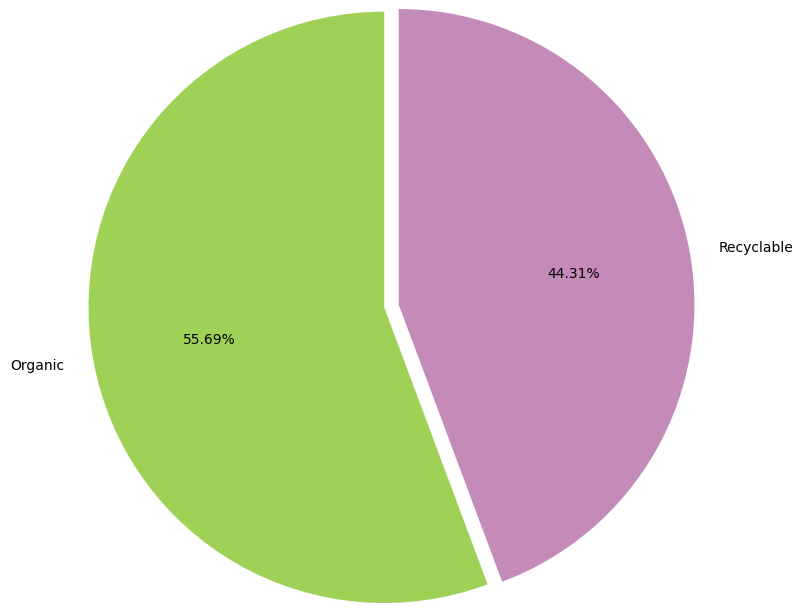

In [9]:
colors = ['#a0d157','#c48bb8']
plt.pie(data.label.value_counts(),startangle=90,explode=[0.05,0.05],autopct='%0.2f%%',
        labels=['Organic', 'Recyclable'], colors= colors,radius=2)
plt.show()

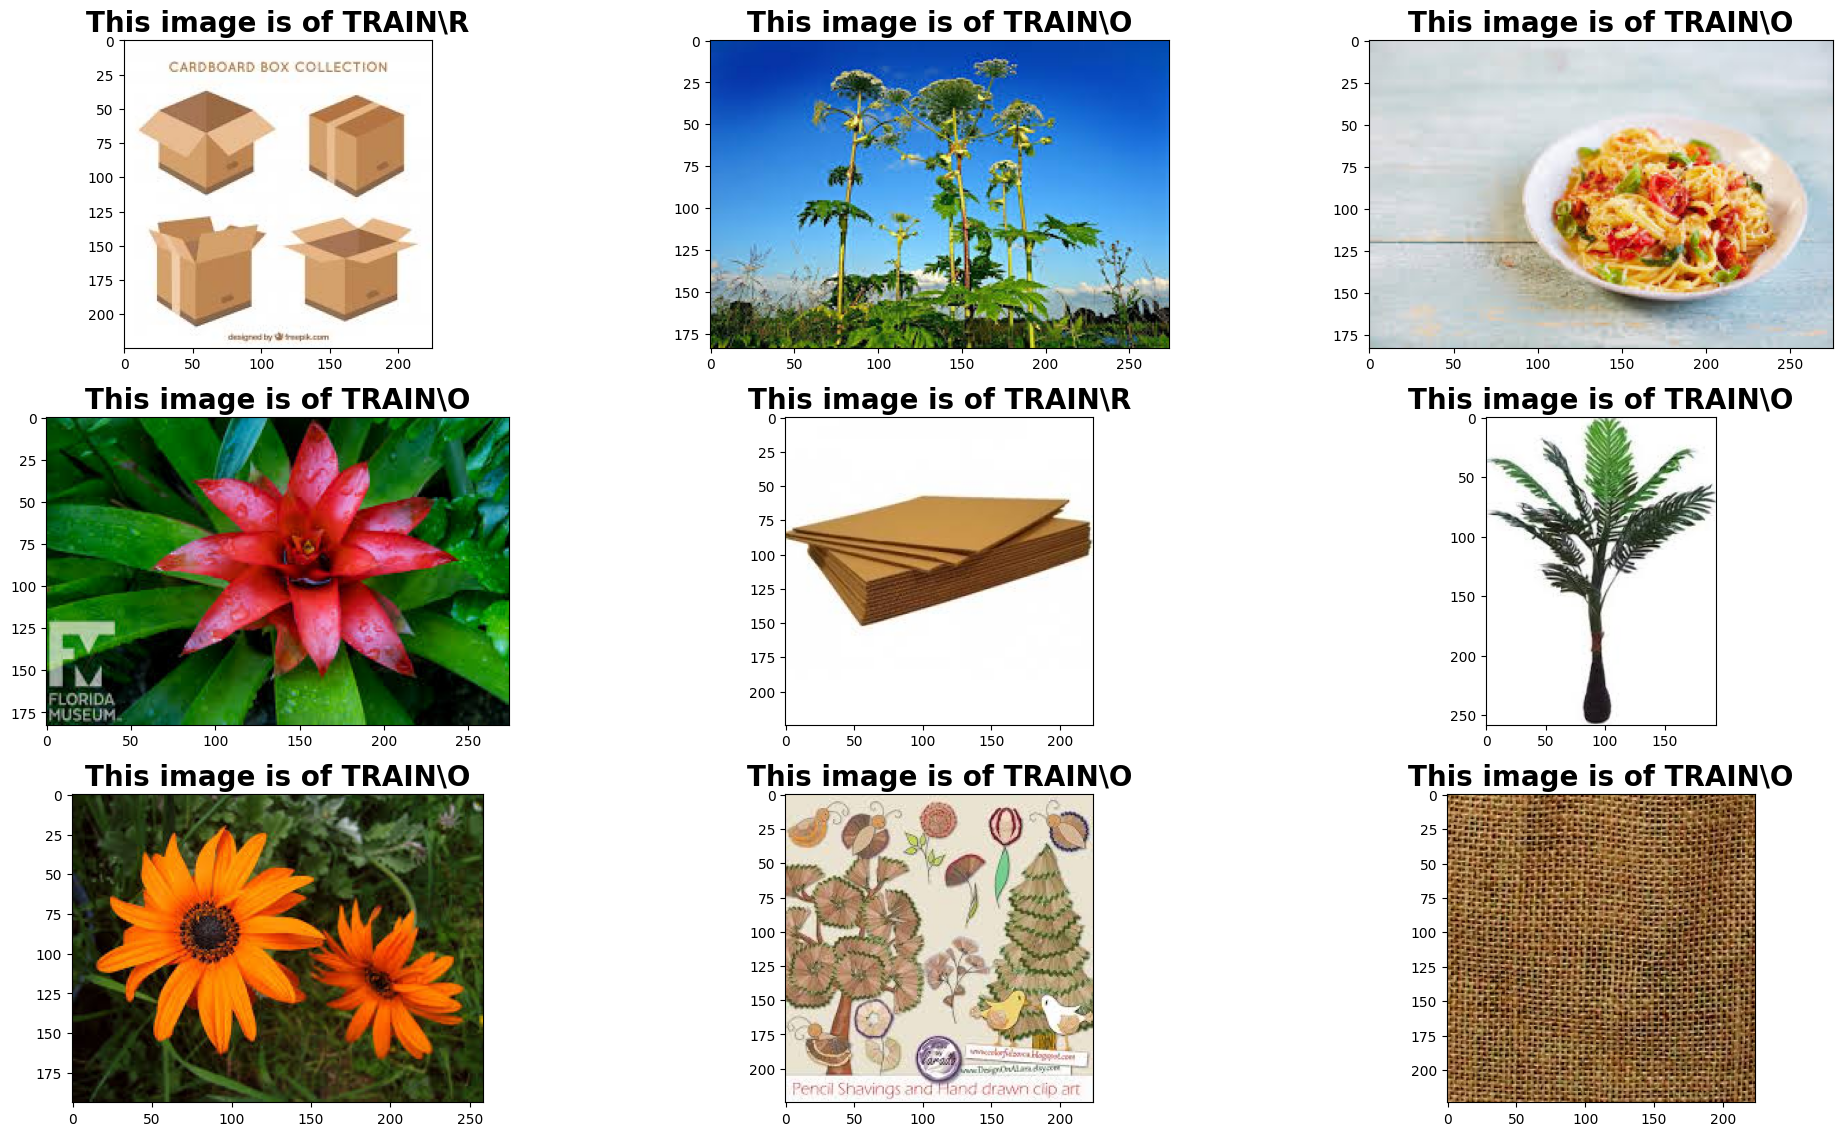

In [10]:
plt.figure(figsize=(20,15))
for i in range(9):
    plt.subplot(4,3,(i%12)+1)
    index=np.random.randint(15000)
    plt.title('This image is of {0}'.format(data.label[index]),fontdict={'size':20,'weight':'bold'})
    plt.imshow(data.image[index])
    plt.tight_layout()

In [11]:
className = glob(train_path + '/*' )
numberOfClass = len(className)
print("Number Of Class: ",numberOfClass)

Number Of Class:  2


In [29]:
from tensorflow.keras.applications import EfficientNetB5
from tensorflow.keras import layers, models

# Load pre-trained EfficientNetB5 without the top classification layer
base_model = EfficientNetB5(weights='imagenet', include_top=False, input_shape=(224, 224, 3))

# Freeze the base model layers to prevent them from being trained
base_model.trainable = False

# Build the new model
model = models.Sequential()

# Add the pre-trained EfficientNetB5 model
model.add(base_model)

# Add custom layers for fine-tuning
model.add(layers.GlobalAveragePooling2D())  # Global average pooling
model.add(layers.Dense(256, activation='relu'))  # Fully connected layer
model.add(layers.Dropout(0.5))  # Dropout for regularization
model.add(layers.Dense(64, activation='relu'))  # Another fully connected layer
model.add(layers.Dropout(0.5))  # Dropout for regularization
model.add(layers.Dense(numberOfClass, activation='sigmoid'))  # Output layer

# Compile the model
model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])


model.compile(loss = "binary_crossentropy",
              optimizer = "adam",
              metrics = ["accuracy"])

batch_size = 50

In [30]:
train_datagen = ImageDataGenerator(rescale= 1./255)

In [31]:
test_datagen = ImageDataGenerator(rescale= 1./255)

In [32]:
train_generator = train_datagen.flow_from_directory(
        train_path, 
        target_size= (224,224),
        batch_size = batch_size,
        color_mode= "rgb",
        class_mode= "categorical")

test_generator = test_datagen.flow_from_directory(
        test_path, 
        target_size= (224,224),
        batch_size = batch_size,
        color_mode= "rgb",
        class_mode= "categorical")

Found 22564 images belonging to 2 classes.
Found 2513 images belonging to 2 classes.


In [33]:
hist = model.fit(
        train_generator,
        epochs=10,
        validation_data = test_generator)

Epoch 1/10
452/452 [==============================] - 252s 489ms/step - loss: 0.6916 - accuracy: 0.5495 - val_loss: 0.6799 - val_accuracy: 0.5575
Epoch 2/10
452/452 [==============================] - 191s 423ms/step - loss: 0.6829 - accuracy: 0.5651 - val_loss: 0.6774 - val_accuracy: 0.5639
Epoch 3/10
452/452 [==============================] - 192s 424ms/step - loss: 0.6800 - accuracy: 0.5706 - val_loss: 0.6586 - val_accuracy: 0.6614
Epoch 4/10
452/452 [==============================] - 192s 424ms/step - loss: 0.6774 - accuracy: 0.5828 - val_loss: 0.6581 - val_accuracy: 0.6789
Epoch 5/10
452/452 [==============================] - 193s 428ms/step - loss: 0.6754 - accuracy: 0.5851 - val_loss: 0.6613 - val_accuracy: 0.6220
Epoch 6/10
452/452 [==============================] - 195s 432ms/step - loss: 0.6735 - accuracy: 0.5916 - val_loss: 0.6649 - val_accuracy: 0.5977
Epoch 7/10
452/452 [==============================] - 195s 431ms/step - loss: 0.6737 - accuracy: 0.5889 - val_loss: 0.6596 -

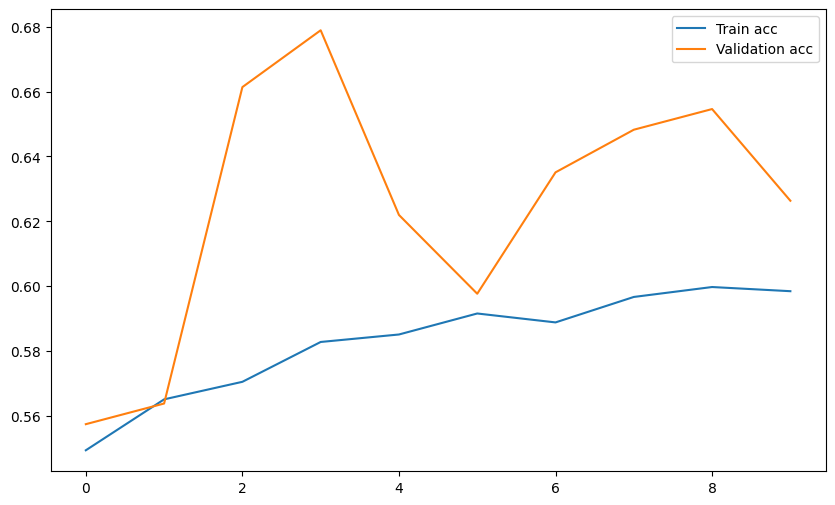

In [34]:
plt.figure(figsize=[10,6])
plt.plot(hist.history["accuracy"], label = "Train acc")
plt.plot(hist.history["val_accuracy"], label = "Validation acc")
plt.legend()
plt.show()

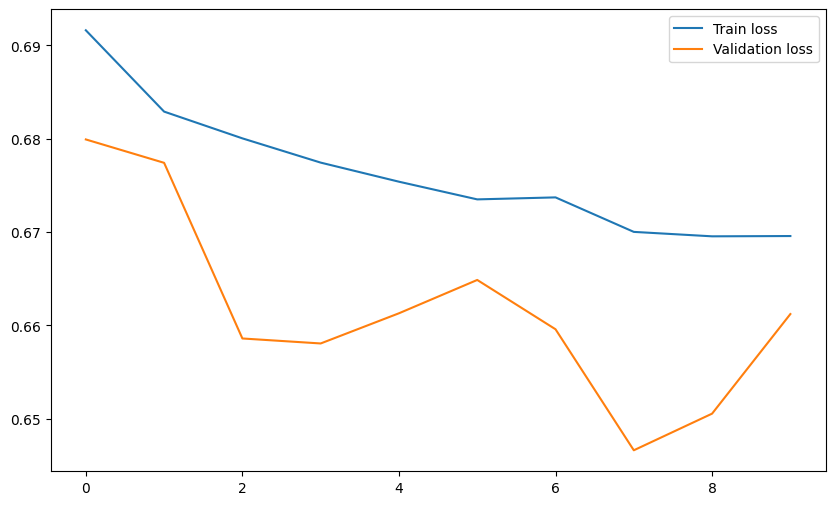

In [35]:
plt.figure(figsize=(10,6))
plt.plot(hist.history['loss'], label = "Train loss")
plt.plot(hist.history['val_loss'], label = "Validation loss")
plt.legend()
plt.show()

In [36]:
def predict_func(img): 
    plt.figure(figsize=(6,4))
    plt.imshow(cv2.cvtColor(img, cv2.COLOR_BGR2RGB))
    plt.tight_layout()
    img = cv2.resize(img, (224, 224))
    img = np.reshape(img, [-1, 224, 224,3])
    result = np.argmax(model.predict(img))
    if result == 0: print("\033[94m"+"This image -> Recyclable"+"\033[0m")
    elif result ==1: print("\033[94m"+"This image -> Organic"+"\033[0m")

In [37]:
test_img = cv2.imread("/kaggle/input/waste-classification-data/DATASET/TEST/O/O_12573.jpg")
predict_func(test_img)

error: OpenCV(4.10.0) D:\a\opencv-python\opencv-python\opencv\modules\imgproc\src\color.cpp:196: error: (-215:Assertion failed) !_src.empty() in function 'cv::cvtColor'


<Figure size 600x400 with 0 Axes>

In [ ]:
test_img = cv2.imread("/kaggle/input/waste-classification-data/DATASET/TEST/R/R_10753.jpg")
predict_func(test_img)